In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Algorithms
from sklearn.neighbors import KNeighborsClassifier

# Internal
from autocat.data.datasets import get_training_data, get_totals_data
from autocat.data.features import CombinedFeatureAdder, feature_transactions_per_day, PandasDataFrameTransformer
from autocat.data.filters import FeatureFilters, no_null_StdUnitsShipped_StdNetAmount
from autocat.models import GridSearchModel, Model
from autocat.models.evaluation import plot_learning_curve, get_scorer, financial_loss_scorer
from autocat.models.pipelines import get_scaled_pipeline_v1

## Pipeline

In [3]:
TRAINING_DATA = '../data/processed/train_2018-08-24.csv'

# Create feaure matrix and label vector
X, y = get_training_data(TRAINING_DATA, [
    no_null_StdUnitsShipped_StdNetAmount
], drop_na=True)

In [4]:
# Get the scaled pipeline
pipeline = get_scaled_pipeline_v1(X)
print(pipeline)

Pipeline(memory=None,
     steps=[('feaure_transactions_per_day', CombinedFeatureAdder(attribute_fn=<function feature_transactions_per_day at 0x108ea4c80>)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('data_frame', PandasDataFrameTransformer(columns=['AvgUnitsShipped', 'StdUnitsShipped', 'MinUnitsShipped', 'MaxUnitsShipped', 'AvgNetAmount', 'StdNetAmount', 'MinNetAmount', 'MaxNetAmount', 'NumberOfTransactions', 'NumberOfTransactionDays', 'TransactionsPerDay']))])


In [5]:
print('Training instances:', len(X))

Training instances: 5610


## Scorer

In [6]:
totals_data = get_totals_data()
scorer = make_scorer(financial_loss_scorer, totals=totals_data, greater_is_better=False)

## Model

In [7]:
# Create the parameter grid to optimize
param_grid = [
    {
        'knn__n_neighbors': [1, 3, 5, 10, 25, 30, 45, 50], 
        'knn__metric': ['euclidean'],
        'knn__weights': ['uniform', 'distance']
    },
   {
       'knn__n_neighbors': [1, 3, 5, 10, 25, 30, 45, 50], 
       'knn__metric': ['minkowski'],
        'knn__weights': ['uniform', 'distance'],
       'knn__p': [1, 3]
    }
  ]

In [8]:
# # Train a model using grid search
# model = GridSearchModel(param_grid, name='knn', model=KNeighborsClassifier(), pipeline=pipeline)
# model.train(X, y, 10, scorer)

# Use existing model
model = Model(
    'knn', 
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
               metric_params=None, n_jobs=1, n_neighbors=25, p=1,
               weights='distance'),
    pipeline)

model.fit(X, y)

In [9]:
model.model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=1,
           weights='distance')

We could tune this to find optimal `n_neighbors` parameter in the range [25,30]

## Evaluation

In [10]:
model_predictions = model.model_pipeline.predict(X)

#### Training Set

In [11]:
results = model.score(X, y, scorer)
print('Score:', results[0])
print(classification_report(y, model.model.predict(model.pipeline.fit_transform(X))))

Score: -0.0
                      precision    recall  f1-score   support

           Body Care       1.00      1.00      1.00       936
              Frozen       0.99      0.99      0.99       308
                Meat       1.00      1.00      1.00       102
    Packaged Grocery       0.99      1.00      1.00      3005
        Packaged Tea       1.00      0.99      0.99       222
Refrigerated Grocery       1.00      0.99      1.00       595
            Vitamins       1.00      0.98      0.99       442

         avg / total       1.00      1.00      1.00      5610



#### Cross Validation

In [12]:
CV=10

##### Financial Loss

In [13]:
cv_scores = cross_val_score(model.get_model_pipeline(), X, y, scoring=scorer, cv=CV)
cv_scores.mean()

-2501029.403

Lower than the SVM model

##### F1

In [14]:
cv_predictions = cross_val_predict(model.get_model_pipeline(), X, y, cv=CV)
print(f1_score(y, cv_predictions, average='micro'))
print(classification_report(y, cv_predictions))

0.6982174688057041
                      precision    recall  f1-score   support

           Body Care       0.67      0.78      0.72       936
              Frozen       0.44      0.01      0.03       308
                Meat       0.90      0.62      0.73       102
    Packaged Grocery       0.72      0.91      0.80      3005
        Packaged Tea       0.52      0.07      0.12       222
Refrigerated Grocery       0.65      0.46      0.54       595
            Vitamins       0.56      0.25      0.34       442

         avg / total       0.67      0.70      0.65      5610



Slightly better recall than SVM gives it an edge

#### Confusion Matrix

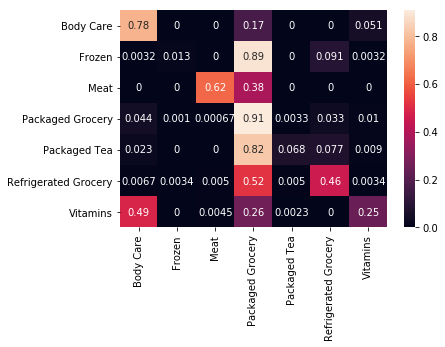

In [17]:
conf_mat = confusion_matrix(y, cv_predictions, labels=np.sort(y.unique()))
conf_mat_df = pd.DataFrame(
    conf_mat, 
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

conf_mat_props = pd.DataFrame(
    conf_mat_df.values / conf_mat_df.sum(axis=1)[:,None],
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

sns.heatmap(conf_mat_props, annot=True);

In [18]:
conf_mat_props.apply(lambda x: (x == 0).sum()).mean()

2.142857142857143

Errors are less sparse meaning more varried errors across clcasses.

#### Learning Curve

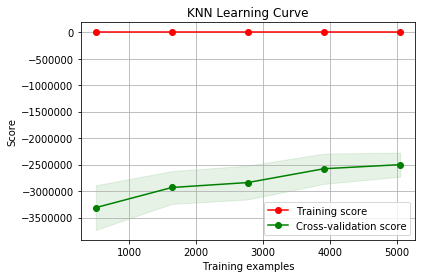

In [11]:
# Plot the learning curve
plot_learning_curve(model.get_model_pipeline(), 'KNN Learning Curve', X, y, cv=CV, scoring=scorer);

Clear overfitting on training set but performs well enough w.r.t. financial loss.

In [15]:
Model.save(model, '../models/knn-financial-loss_2018-09-04.model')